# XGBoost

In [7]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
random.seed(42)

from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, average_precision_score,
                             confusion_matrix, roc_curve)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from tqdm.auto import tqdm
from sklearn.model_selection import GridSearchCV


In [8]:
# --- 1. Import train/test/validation CSV files with the correct index ---
data_path = '/Volumes/Seagate External HD 1/Independent Study/NYTRestaurantReviews/data/modeling'
train_df = pd.read_csv(os.path.join(data_path, 'train.csv'), index_col='Restaurant_name')
test_df = pd.read_csv(os.path.join(data_path, 'test.csv'), index_col='Restaurant_name')
val_df = pd.read_csv(os.path.join(data_path, 'validation.csv'), index_col='Restaurant_name')


Train Metrics:
Accuracy: 0.9872
Precision: 1.0000
Recall: 0.8021
F1 Score: 0.8902
ROC-AUC: 0.9996
PR-AUC: 0.9946

Test Metrics:
Accuracy: 0.9640
Precision: 0.9271
Recall: 0.4785
F1 Score: 0.6312
ROC-AUC: 0.9213
PR-AUC: 0.6841

Validation Metrics:
Accuracy: 0.9706
Precision: 0.9180
Recall: 0.5989
F1 Score: 0.7249
ROC-AUC: 0.9056
PR-AUC: 0.7250


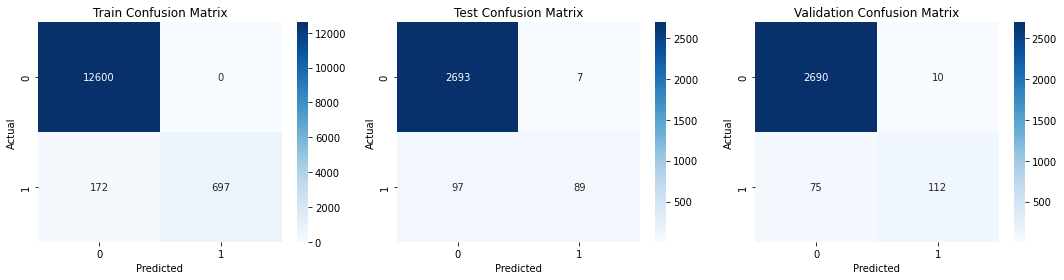

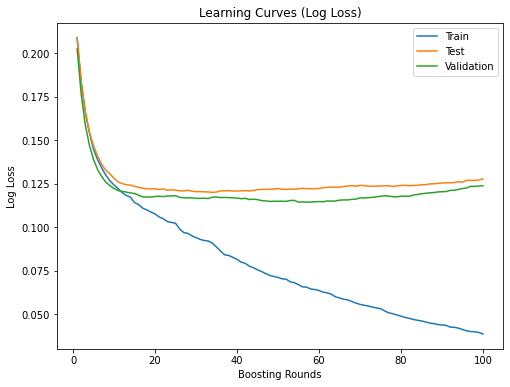

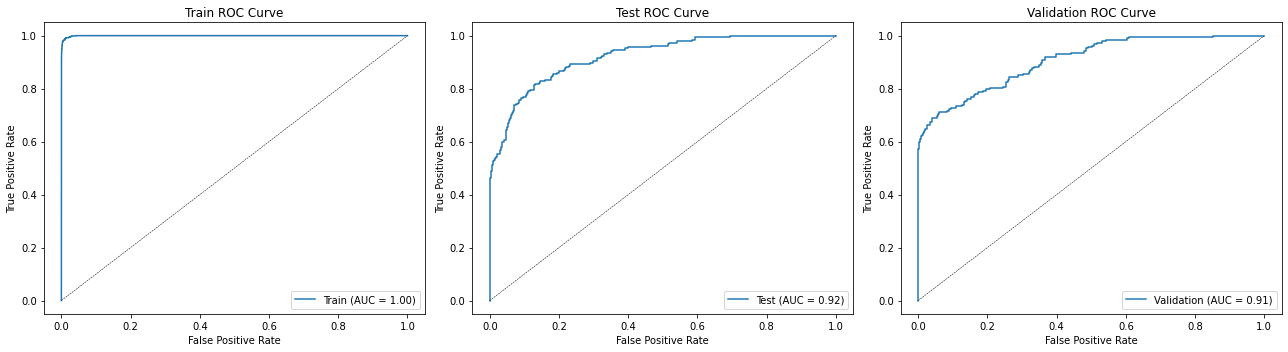


Top 10 Feature Importances:


,feature,importance
0,Wealthy_Zip,0.694036
12,boro_name_Manhattan,0.043182
15,Median Income,0.030306
18,Spanish,0.017572
6,Cuisine_Category_Middle Eastern,0.017288
26,College Graduates (%),0.012236
4,Cuisine_Category_European,0.011658
2,Cuisine_Category_American,0.011628
13,boro_name_Queens,0.011422
17,English,0.011196


In [9]:

# Separate features (X) and target (y). Assuming the target column is 'Reviewed by NYT'
X_train = train_df.drop(columns=['Reviewed by NYT'])
y_train = train_df['Reviewed by NYT']

X_test = test_df.drop(columns=['Reviewed by NYT'])
y_test = test_df['Reviewed by NYT']

X_val = val_df.drop(columns=['Reviewed by NYT'])
y_val = val_df['Reviewed by NYT']

# --- 2. (Optional) Define the Preprocessor ---
# Although defined here, note that we will NOT apply it for the XGBoost pipeline.
# If you ever need it for other models, you can use it.
numerical_cols = X_train.select_dtypes(include=['float64']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols)
    ],
    remainder='passthrough'
)

# --- 3. Build the Baseline XGBoost Pipeline without Scaling ---
xgb_clf = XGBClassifier(use_label_encoder=False, 
                          eval_metric='logloss',
                          random_state=42)

# Note: We intentionally do not include the preprocessor in this pipeline.
pipeline = Pipeline(steps=[
    ('classifier', xgb_clf)
])

# Fit the pipeline with evaluation sets so we can track the learning curves.
pipeline.fit(
    X_train, y_train, 
    classifier__eval_set=[(X_train, y_train), (X_test, y_test), (X_val, y_val)],
    classifier__verbose=False
)

# Retrieve the evaluation history for the learning curve.
evals_result = pipeline.named_steps['classifier'].evals_result()

# --- 4. Define Helper Functions for Metrics and Plotting ---
def compute_metrics(y_true, y_pred, y_proba):
    metrics = {}
    metrics['Accuracy']   = accuracy_score(y_true, y_pred)
    metrics['Precision']  = precision_score(y_true, y_pred, zero_division=0)
    metrics['Recall']     = recall_score(y_true, y_pred, zero_division=0)
    metrics['F1 Score']   = f1_score(y_true, y_pred, zero_division=0)
    if y_proba is not None:
        metrics['ROC-AUC'] = roc_auc_score(y_true, y_proba)
        metrics['PR-AUC']  = average_precision_score(y_true, y_proba)
    else:
        metrics['ROC-AUC'] = np.nan
        metrics['PR-AUC']  = np.nan
    return metrics

def print_metrics_and_confusion(name, X, y):
    y_pred = pipeline.predict(X)
    # Use predict_proba if available.
    if hasattr(pipeline.named_steps['classifier'], "predict_proba"):
        y_proba = pipeline.predict_proba(X)[:, 1]
    else:
        y_proba = None
    
    metrics = compute_metrics(y, y_pred, y_proba)
    print(f"\n{name} Metrics:")
    for metric, val in metrics.items():
        print(f"{metric}: {val:.4f}")
    
    cm = confusion_matrix(y, y_pred)
    return cm

# --- 5. Compute Metrics and Confusion Matrices ---
cm_train = print_metrics_and_confusion("Train", X_train, y_train)
cm_test  = print_metrics_and_confusion("Test", X_test, y_test)
cm_val   = print_metrics_and_confusion("Validation", X_val, y_val)

# --- 6. Plot the Confusion Matrices in a 1x3 Row ---
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
cms = [cm_train, cm_test, cm_val]
titles = ['Train Confusion Matrix', 'Test Confusion Matrix', 'Validation Confusion Matrix']

for ax, cm, title in zip(axes, cms, titles):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
plt.tight_layout()
plt.show()

# --- 7. Plot the Learning Curve ---
plt.figure(figsize=(8, 6))
n_rounds = len(evals_result['validation_0']['logloss'])
rounds = range(1, n_rounds+1)
plt.plot(rounds, evals_result['validation_0']['logloss'], label='Train')
plt.plot(rounds, evals_result['validation_1']['logloss'], label='Test')
plt.plot(rounds, evals_result['validation_2']['logloss'], label='Validation')
plt.xlabel("Boosting Rounds")
plt.ylabel("Log Loss")
plt.title("Learning Curves (Log Loss)")
plt.legend()
plt.show()

# --- 8. Plot the ROC-AUC Curves for Each Split ---
def plot_roc_curve(ax, X, y, label_name):
    if hasattr(pipeline.named_steps['classifier'], "predict_proba"):
        y_proba = pipeline.predict_proba(X)[:, 1]
    else:
        y_proba = None
    fpr, tpr, _ = roc_curve(y, y_proba)
    roc_auc = roc_auc_score(y, y_proba)
    ax.plot(fpr, tpr, label=f'{label_name} (AUC = {roc_auc:.2f})')
    ax.plot([0, 1], [0, 1], 'k--', lw=0.5)
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'{label_name} ROC Curve')
    ax.legend(loc='lower right')

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
plot_roc_curve(axes[0], X_train, y_train, "Train")
plot_roc_curve(axes[1], X_test, y_test, "Test")
plot_roc_curve(axes[2], X_val, y_val, "Validation")
plt.tight_layout()
plt.show()

# --- 9. Print the Top 10 Feature Importances ---
# For XGBoost, we can retrieve feature importances directly from the classifier.
# Note: Since no preprocessor is applied, we use the original X_train column names.
feature_names = X_train.columns

importances = pipeline.named_steps['classifier'].feature_importances_
feat_imp_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print("\nTop 10 Feature Importances:")
feat_imp_df.head(10)

Grid Search:   0%|          | 0/27 [00:00<?, ?it/s]

Fitting 3 folds for each of 27 candidates, totalling 81 fits


Grid Search:   0%|          | 0/27 [00:33<?, ?it/s]



Best Parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 7, 'classifier__n_estimators': 50}

Train Metrics:
Accuracy: 0.9638
Precision: 1.0000
Recall: 0.4396
F1 Score: 0.6107
ROC-AUC: 0.9618
PR-AUC: 0.7796

Test Metrics:
Accuracy: 0.9619
Precision: 0.9634
Recall: 0.4247
F1 Score: 0.5896
ROC-AUC: 0.9262
PR-AUC: 0.6806

Validation Metrics:
Accuracy: 0.9688
Precision: 1.0000
Recall: 0.5187
F1 Score: 0.6831
ROC-AUC: 0.9073
PR-AUC: 0.7006


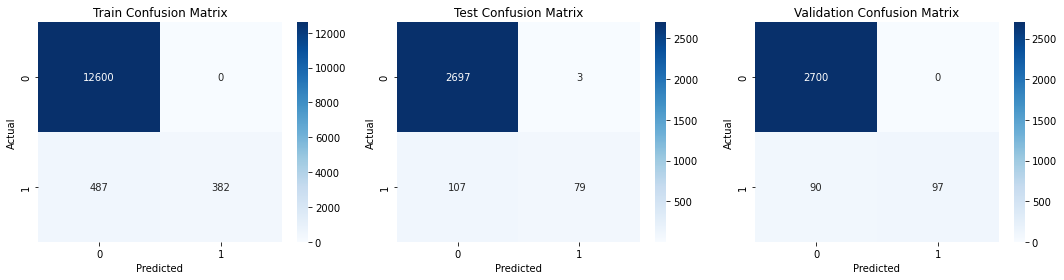

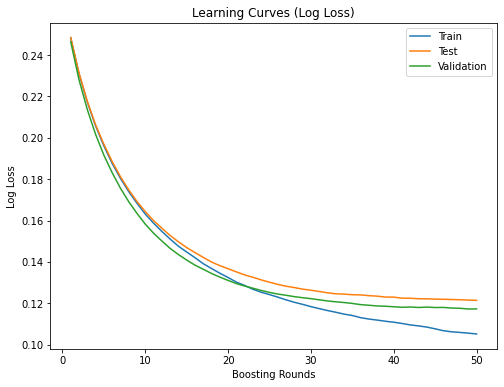

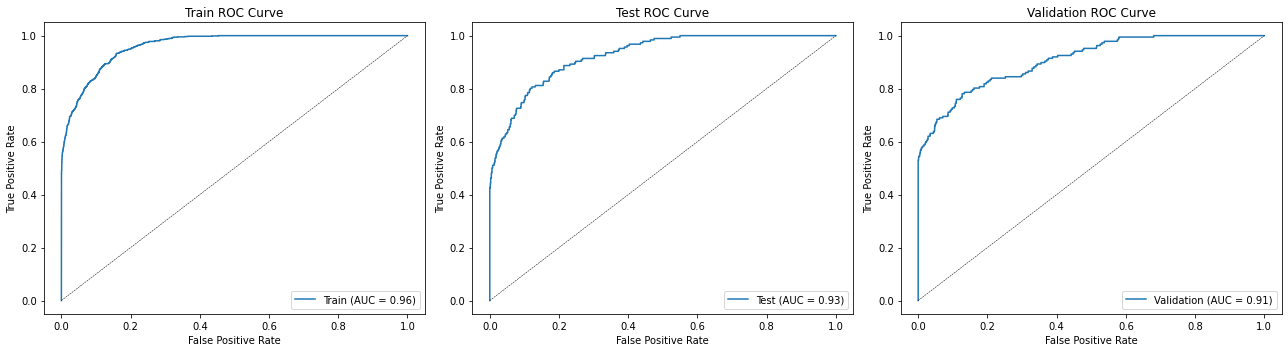


Top 10 Feature Importances:
                            feature  importance
0                       Wealthy_Zip    0.640921
12              boro_name_Manhattan    0.054451
15                    Median Income    0.040491
18                          Spanish    0.024869
21                  Other Languages    0.016923
17                          English    0.016911
6   Cuisine_Category_Middle Eastern    0.016515
23                         Bachelor    0.015994
2         Cuisine_Category_American    0.015206
26            College Graduates (%)    0.014397

Train DataFrame with Classification:
                            Wealthy_Zip  Cuisine_Category_African  \
Restaurant_name                                                     
WO HOP 17                             0                         0   
SAPPS                                 0                         0   
TIMES SQUARE DINER & GRILL            0                         0   
JERUSALEM PITA HOT                    0                     

In [14]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, average_precision_score,
                             confusion_matrix, roc_curve)
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

# For the progress bar with joblib
from tqdm.auto import tqdm

# --- 1. Import train/test/validation CSV files with the correct index ---
data_path = '/Volumes/Seagate External HD 1/Independent Study/NYTRestaurantReviews/data/modeling'
train_df = pd.read_csv(os.path.join(data_path, 'train.csv'), index_col='Restaurant_name')
test_df = pd.read_csv(os.path.join(data_path, 'test.csv'), index_col='Restaurant_name')
val_df = pd.read_csv(os.path.join(data_path, 'validation.csv'), index_col='Restaurant_name')

# Separate features (X) and target (y). Assuming the target column is 'Reviewed by NYT'
X_train = train_df.drop(columns=['Reviewed by NYT'])
y_train = train_df['Reviewed by NYT']

X_test = test_df.drop(columns=['Reviewed by NYT'])
y_test = test_df['Reviewed by NYT']

X_val = val_df.drop(columns=['Reviewed by NYT'])
y_val = val_df['Reviewed by NYT']

# --- 2. Build the Baseline XGBoost Pipeline (without scaling) ---
xgb_clf = XGBClassifier(use_label_encoder=False, 
                          eval_metric='logloss',
                          random_state=42)

pipeline = Pipeline(steps=[
    ('classifier', xgb_clf)
])

# --- 3. Define the Hyperparameter Grid ---
param_grid = {
    'classifier__n_estimators': [50, 100, 150],
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.01, 0.1, 0.2]
}

# Determine total iterations using ParameterGrid
total_iterations = len(list(ParameterGrid(param_grid)))

# --- 4. Perform Grid Search with Progress Bar ---
grid = GridSearchCV(pipeline, param_grid=param_grid, scoring='roc_auc', cv=3, n_jobs=-1, verbose=1)

with tqdm(desc="Grid Search", total=total_iterations):
    grid.fit(X_train, y_train)

print("\nBest Parameters:", grid.best_params_)

# Use the best estimator from the grid search.
best_pipeline = grid.best_estimator_

# --- 5. Fit the Best Estimator with Evaluation Sets for Learning Curve ---
best_pipeline.fit(
    X_train, y_train, 
    classifier__eval_set=[(X_train, y_train), (X_test, y_test), (X_val, y_val)],
    classifier__verbose=False
)

# Retrieve evaluation history
evals_result = best_pipeline.named_steps['classifier'].evals_result()

# --- 6. Define Helper Functions for Metrics and Plotting ---
def compute_metrics(y_true, y_pred, y_proba):
    metrics = {}
    metrics['Accuracy']   = accuracy_score(y_true, y_pred)
    metrics['Precision']  = precision_score(y_true, y_pred, zero_division=0)
    metrics['Recall']     = recall_score(y_true, y_pred, zero_division=0)
    metrics['F1 Score']   = f1_score(y_true, y_pred, zero_division=0)
    if y_proba is not None:
        metrics['ROC-AUC'] = roc_auc_score(y_true, y_proba)
        metrics['PR-AUC']  = average_precision_score(y_true, y_proba)
    else:
        metrics['ROC-AUC'] = np.nan
        metrics['PR-AUC']  = np.nan
    return metrics

def print_metrics_and_confusion(name, X, y):
    y_pred = best_pipeline.predict(X)
    if hasattr(best_pipeline.named_steps['classifier'], "predict_proba"):
        y_proba = best_pipeline.predict_proba(X)[:, 1]
    else:
        y_proba = None
    
    metrics = compute_metrics(y, y_pred, y_proba)
    print(f"\n{name} Metrics:")
    for metric, val in metrics.items():
        print(f"{metric}: {val:.4f}")
    
    cm = confusion_matrix(y, y_pred)
    return cm

# --- 7. Compute Metrics and Confusion Matrices ---
cm_train = print_metrics_and_confusion("Train", X_train, y_train)
cm_test  = print_metrics_and_confusion("Test", X_test, y_test)
cm_val   = print_metrics_and_confusion("Validation", X_val, y_val)

# --- 8. Plot the Confusion Matrices in a 1x3 Row ---
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
cms = [cm_train, cm_test, cm_val]
titles = ['Train Confusion Matrix', 'Test Confusion Matrix', 'Validation Confusion Matrix']

for ax, cm, title in zip(axes, cms, titles):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
plt.tight_layout()
plt.show()

# --- 9. Plot the Learning Curve ---
plt.figure(figsize=(8, 6))
n_rounds = len(evals_result['validation_0']['logloss'])
rounds = range(1, n_rounds+1)
plt.plot(rounds, evals_result['validation_0']['logloss'], label='Train')
plt.plot(rounds, evals_result['validation_1']['logloss'], label='Test')
plt.plot(rounds, evals_result['validation_2']['logloss'], label='Validation')
plt.xlabel("Boosting Rounds")
plt.ylabel("Log Loss")
plt.title("Learning Curves (Log Loss)")
plt.legend()
plt.show()

# --- 10. Plot the ROC-AUC Curves for Each Split ---
def plot_roc_curve(ax, X, y, label_name):
    if hasattr(best_pipeline.named_steps['classifier'], "predict_proba"):
        y_proba = best_pipeline.predict_proba(X)[:, 1]
    else:
        y_proba = None
    fpr, tpr, _ = roc_curve(y, y_proba)
    roc_auc = roc_auc_score(y, y_proba)
    ax.plot(fpr, tpr, label=f'{label_name} (AUC = {roc_auc:.2f})')
    ax.plot([0, 1], [0, 1], 'k--', lw=0.5)
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'{label_name} ROC Curve')
    ax.legend(loc='lower right')

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
plot_roc_curve(axes[0], X_train, y_train, "Train")
plot_roc_curve(axes[1], X_test, y_test, "Test")
plot_roc_curve(axes[2], X_val, y_val, "Validation")
plt.tight_layout()
plt.show()

# --- 11. Print the Top 10 Feature Importances ---
# Since no preprocessor is used, we rely on the original feature names from X_train.
feature_names = X_train.columns
importances = best_pipeline.named_steps['classifier'].feature_importances_
feat_imp_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print("\nTop 10 Feature Importances:")
print(feat_imp_df.head(10))

# --- 12. Save Predictions to DataFrames ---
# Add a new column 'Classification' to each dataset using the model predictions.
train_df['Classification'] = best_pipeline.predict(X_train)
test_df['Classification'] = best_pipeline.predict(X_test)
val_df['Classification'] = best_pipeline.predict(X_val)

# Optionally, print the first few rows to verify the new column
print("\nTrain DataFrame with Classification:")
print(train_df.head())
print("\nTest DataFrame with Classification:")
print(test_df.head())
print("\nValidation DataFrame with Classification:")
print(val_df.head())


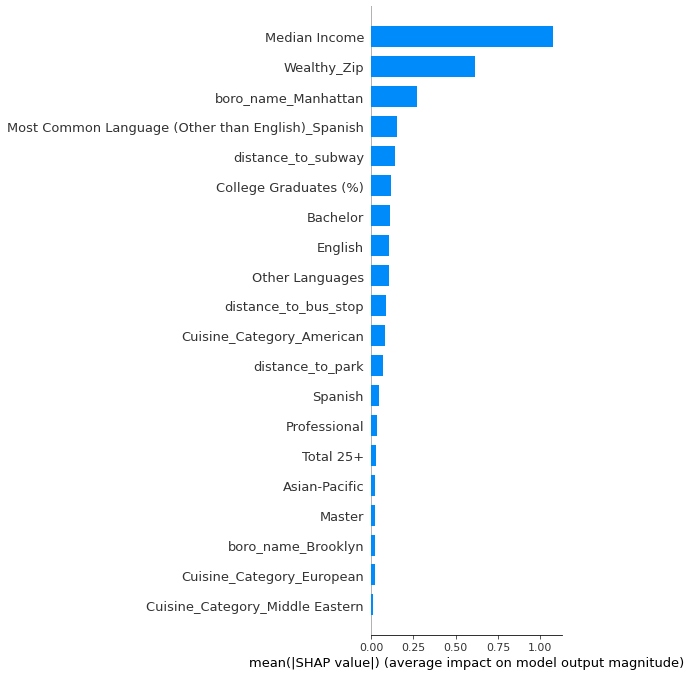

In [15]:
# --- 12. Compute and Plot SHAP Values ---
import shap

# Create a TreeExplainer for the final XGBoost model
explainer = shap.TreeExplainer(best_pipeline.named_steps['classifier'])

# Compute SHAP values for the training set
shap_values = explainer.shap_values(X_train)

# Display a SHAP summary plot (bar plot)
shap.summary_plot(shap_values, X_train, plot_type="bar")

In [20]:
val_df['Classification'].value_counts(normalize=True)

0    0.966401
1    0.033599
Name: Classification, dtype: float64